<center> 
    <h3>Machine Learning Project</h3>
    <h1>"Hierarchical Text Classification for Amazon Reviews"</h1>
    <!-- <br> -->
    <h4></h4>
    <h3>Seyed Mohammad Hossein Hashemi</h3>
    <h5>April 2025</h5>
    <h1></h1>

</center>

# EDA

In [1]:
import re
import nltk
import warnings
import numpy as np
import tqdm as tqdm
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from math import *
from tqdm import tqdm
from nltk.corpus import stopwords
from pycaret.classification import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laste\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Nothing just reading both train and val and putting them all to gether (Pycaret will handle the split)
df_1 = pd.read_csv("train_40k.csv")
df_2 = pd.read_csv("val_10k.csv")
df_1 = df_1.reset_index(drop=True) # just to make sure the indexes wont cause any problems ...
df_2 = df_2.reset_index(drop=True)
df = pd.concat([df_1, df_2], axis=0)
del df_1, df_2 # No longer needed

In [3]:
df # Shape should be 50k*10

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B000E46LYG,Golden Valley Natural Buffalo Jerky,A3MQDNGHDJU4MK,0/0,3.0,-1,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,B000GRA6N8,Westing Game,unknown,0/0,5.0,860630400,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,B000GRA6N8,Westing Game,unknown,0/0,5.0,883008000,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,B000GRA6N8,Westing Game,unknown,0/0,5.0,897696000,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,B00000DMDQ,I SPY A is For Jigsaw Puzzle 63pc,unknown,2/4,5.0,911865600,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles
...,...,...,...,...,...,...,...,...,...,...
9995,B000FGDDI0,Sunbeam 732-500 King Size Heating Pad with Ult...,A3RUBUKF0YX4C7,0/0,4.0,1362182400,Stays on continuously without shutting off! It...,health personal care,health care,pain relievers
9996,B000FVC78C,Reef One Biorb Easy Plants,A1O9H18FJG81FS,0/0,4.0,1362182400,these look great in our 10 gallon tank- colors...,pet supplies,fish aquatic pets,aquarium d cor
9997,B000ICJ8DA,Snoozer Lookout II Pet Car Seat,A3D96MTZP9C1Y,0/0,4.0,1362182400,"This works great, but needs a better way to at...",pet supplies,dogs,carriers travel products
9998,B000Q7AH3W,Omega Paw Tricky Treat Ball,A37L6DBOH234BC,0/0,5.0,1362182400,she absolutely LOVES this thing. I dice up gre...,pet supplies,dogs,toys


In [4]:
df["Cat1"].unique()

array(['grocery gourmet food', 'toys games', 'beauty',
       'health personal care', 'baby products', 'pet supplies'],
      dtype=object)

In [5]:
len(df["Cat1"].unique())

6

In [6]:
df["Cat2"].unique()

array(['meat poultry', 'games', 'puzzles', 'beverages', 'makeup',
       'arts crafts', 'action toy figures', 'dolls accessories',
       'baby toddler toys', 'personal care', 'nutrition wellness',
       'learning education', 'electronics for kids', 'household supplies',
       'stuffed animals plush', 'tricycles', 'health care', 'gear',
       'skin care', 'grown up toys', 'dress up pretend play',
       'novelty gag toys', 'bath body', 'tools accessories', 'hair care',
       'medical supplies equipment', 'baby child care', 'building toys',
       'gifts', 'sexual wellness', 'sports outdoor play', 'hobbies',
       'feeding', 'diapering', 'safety', 'nursery', 'bathing skin care',
       'vehicles remote control', 'car seats accessories', 'strollers',
       'pregnancy maternity', 'cats', 'potty training', 'dogs',
       'gourmet gifts', 'sauces dips', 'breakfast foods',
       'pantry staples', 'fragrance', 'fresh flowers live indoor plants',
       'breads bakery', 'candy chocolate

In [7]:
len(df["Cat2"].unique())

64

In [8]:
df["Cat3"].unique()

array(['jerky', 'unknown', 'jigsaw puzzles', 'board games', 'juices',
       'nails', 'drawing painting supplies', 'figures', 'dolls',
       'card games', 'drawing sketching tablets', 'shape sorters',
       'deodorants antiperspirants', 'nutrition bars drinks', 'habitats',
       'household batteries', 'push pull toys', 'scooters wagons',
       'clay dough', 'allergy', 'baby gyms playmats',
       'shaving hair removal', 'face', 'animals figures', 'feminine care',
       'music sound', 'oral hygiene', 'pretend play', 'cleansers',
       'playsets', 'd puzzles', 'dollhouses', 'lip care products',
       'nail tools', 'eye care', 'pill cases splitters',
       'styling products', 'electronic toys', 'body', 'toy balls', 'eyes',
       'trading card games', 'foot care', 'hands nails', 'sun',
       'daily living aids', 'personal care', 'paper plastic',
       'incontinence', 'shampoos', 'conditioners',
       'music players karaoke', 'cough cold', 'bath', 'tests',
       'building sets'

In [9]:
len(df["Cat3"].unique())

473

Some datapoint labels seems to be missing. Expected to get 510!

In [10]:
df["Cat1"].value_counts(normalize=True)*100

Cat1
health personal care    25.528
toys games              24.050
beauty                  15.962
pet supplies            12.876
baby products           12.670
grocery gourmet food     8.914
Name: proportion, dtype: float64

In [11]:
df["Cat2"].value_counts(normalize=True)*100

Cat2
dogs                  6.970
personal care         6.760
nutrition wellness    6.214
health care           5.300
hair care             4.630
                      ...  
produce               0.090
meat poultry          0.090
baby food             0.084
meat seafood          0.084
small animals         0.080
Name: proportion, Length: 64, dtype: float64

In [12]:
df["Cat3"].value_counts(normalize=True)*100

Cat3
unknown                 5.498
vitamins supplements    3.960
shaving hair removal    3.690
styling tools           2.126
board games             2.096
                        ...  
games                   0.002
odor stain removers     0.002
beverages               0.002
p t s                   0.002
breeding tanks          0.002
Name: proportion, Length: 473, dtype: float64

In [13]:
df.isnull().sum().sort_values(ascending=False)

Title          21
productId       0
userId          0
Helpfulness     0
Score           0
Time            0
Text            0
Cat1            0
Cat2            0
Cat3            0
dtype: int64

Its seems we have about 16 samples that have Null values in their "Title" column 

In [14]:
(df.isnull().sum() / len(df)).sort_values(ascending=False)

Title          0.00042
productId      0.00000
userId         0.00000
Helpfulness    0.00000
Score          0.00000
Time           0.00000
Text           0.00000
Cat1           0.00000
Cat2           0.00000
Cat3           0.00000
dtype: float64

Regarding the Null values,

We could have gone for Value Imputation strategies but since the total number of Null values is so negligable, we decide to drop those samples for now.

In [15]:
df[df.isnull().any(axis=1)]

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
3786,B000UICQZO,NaN,A2D1T6Z5EYJ7WY,4/18,1.0,1109894400,EWWW EWWW GET IT OFF GET IT OFF!!!!!!!!!!!!!!!...,beauty,fragrance,unknown
5202,B0009S3K1E,NaN,A2PWSZJ1Q21NYQ,0/1,5.0,1131408000,i bought this for my wife last christmas for l...,beauty,fragrance,unknown
7340,B0001Y6DUG,NaN,AW18N7F16XTR4,0/0,5.0,1163030400,This is one of my favorite lip balms ever! It'...,beauty,makeup,lips
9374,B00028MIKK,NaN,A1H7CKOA2DQJU0,2/2,5.0,1178409600,"This tea is really, really good -- it's very s...",grocery gourmet food,beverages,tea
12117,B000KGRNMM,NaN,A2EVLYSFT7IDC6,99/100,5.0,1199232000,I needed a nail kit to take care of my Mother'...,health personal care,medical supplies equipment,daily living aids
13089,B000GUFFQS,NaN,A1P0IHM5P5WVOZ,1/1,5.0,1204934400,My 93 year old father in law recently fell (lu...,health personal care,medical supplies equipment,beds accessories
14881,B000KGRNMM,NaN,A3V0HBE74ZUFKB,52/52,5.0,1218672000,I am delighted with my nail care kit. I am in ...,health personal care,medical supplies equipment,daily living aids
18850,B000634EEO,NaN,A3A6B6RYANZYJN,6/6,1.0,1244937600,"We bought this yesterday at Petco. Our betta, ...",pet supplies,fish aquatic pets,aquarium starter kits
19395,B000GUFFQS,NaN,A1W0PU8IJ06LJJ,3/3,5.0,1249603200,I put this on my grandmother's bed. It was ver...,health personal care,medical supplies equipment,beds accessories
20193,B000GUFFQS,NaN,A3URJ91T1WXQHE,1/1,5.0,1255392000,"My father, who had a stroke several years ago,...",health personal care,medical supplies equipment,beds accessories


In [16]:
new_df = df.dropna()
new_df[new_df.isnull().any(axis=1)]

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3


No Null Values left!

Lets drop the "productId", "userId" and "Time" as they seem to be irrrelavant to the classification label

In [17]:
new_df = new_df.drop(['productId', 'userId', 'Time'], axis=1)
new_df.head(3)

,Title,Helpfulness,Score,Text,Cat1,Cat2,Cat3
0,Golden Valley Natural Buffalo Jerky,0/0,3.0,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,Westing Game,0/0,5.0,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,Westing Game,0/0,5.0,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown


One issue on Cat3 labels: unknown class!

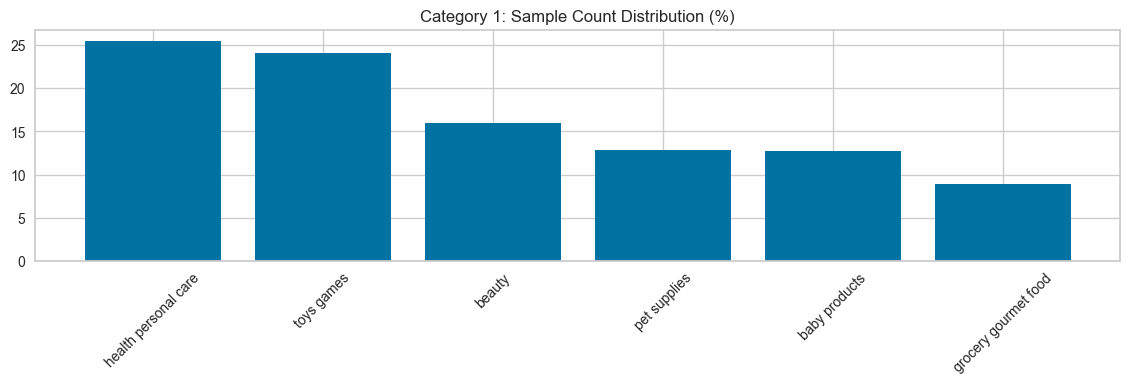

In [18]:
values = (new_df["Cat1"].value_counts(normalize=True) * 100).values.tolist()
columns = (new_df["Cat1"].value_counts(normalize=True) * 100).keys().tolist()

plt.figure(figsize=(14, 3))
plt.bar(columns, values)
plt.xticks(rotation=45)  
plt.title("Category 1: Sample Count Distribution (%)")
plt.show()

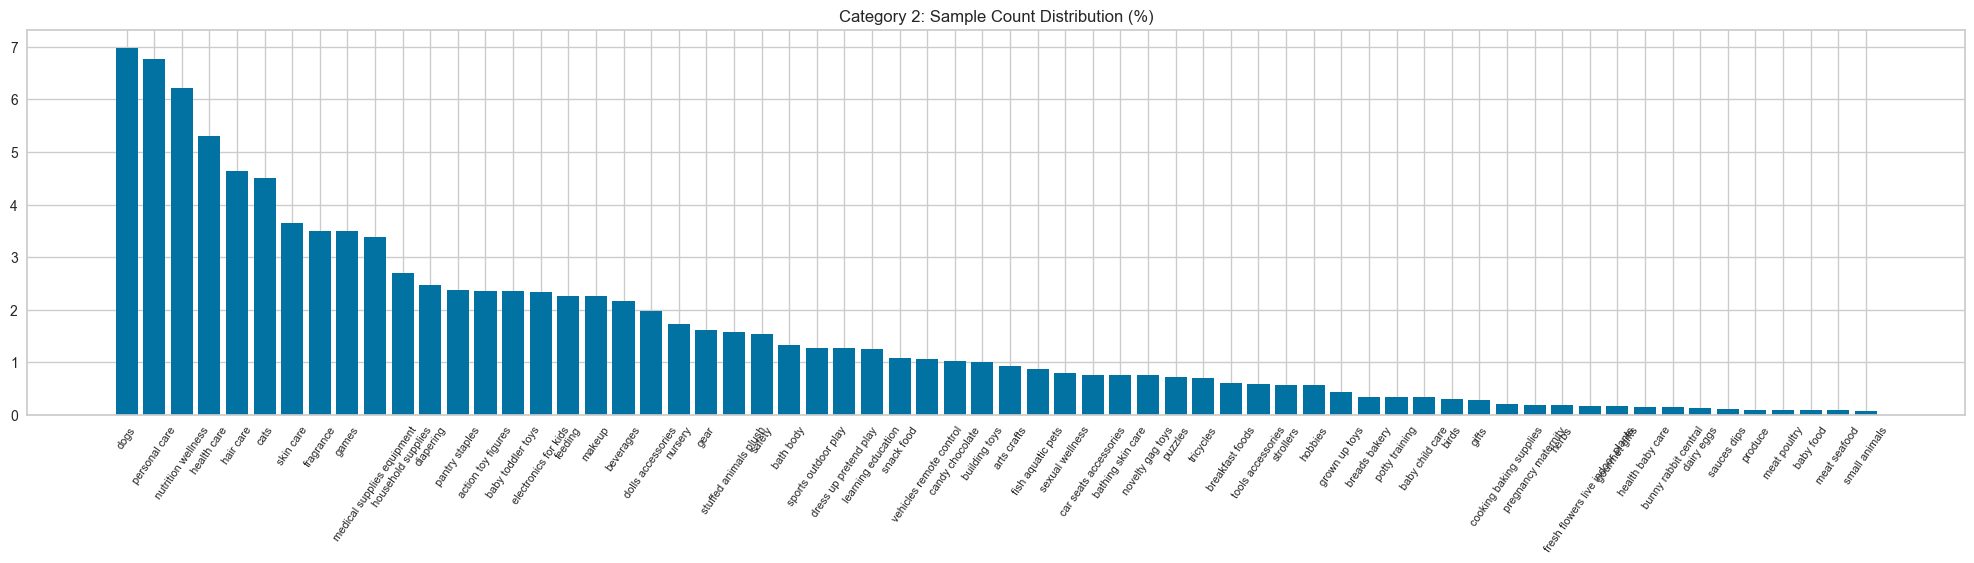

In [19]:
values = (new_df["Cat2"].value_counts(normalize=True) * 100).values.tolist()
columns = (new_df["Cat2"].value_counts(normalize=True) * 100).keys().tolist()

plt.figure(figsize=(25, 5))
plt.bar(columns, values)
plt.xticks(rotation=55, fontsize=8)  
plt.title("Category 2: Sample Count Distribution (%)")
plt.show()

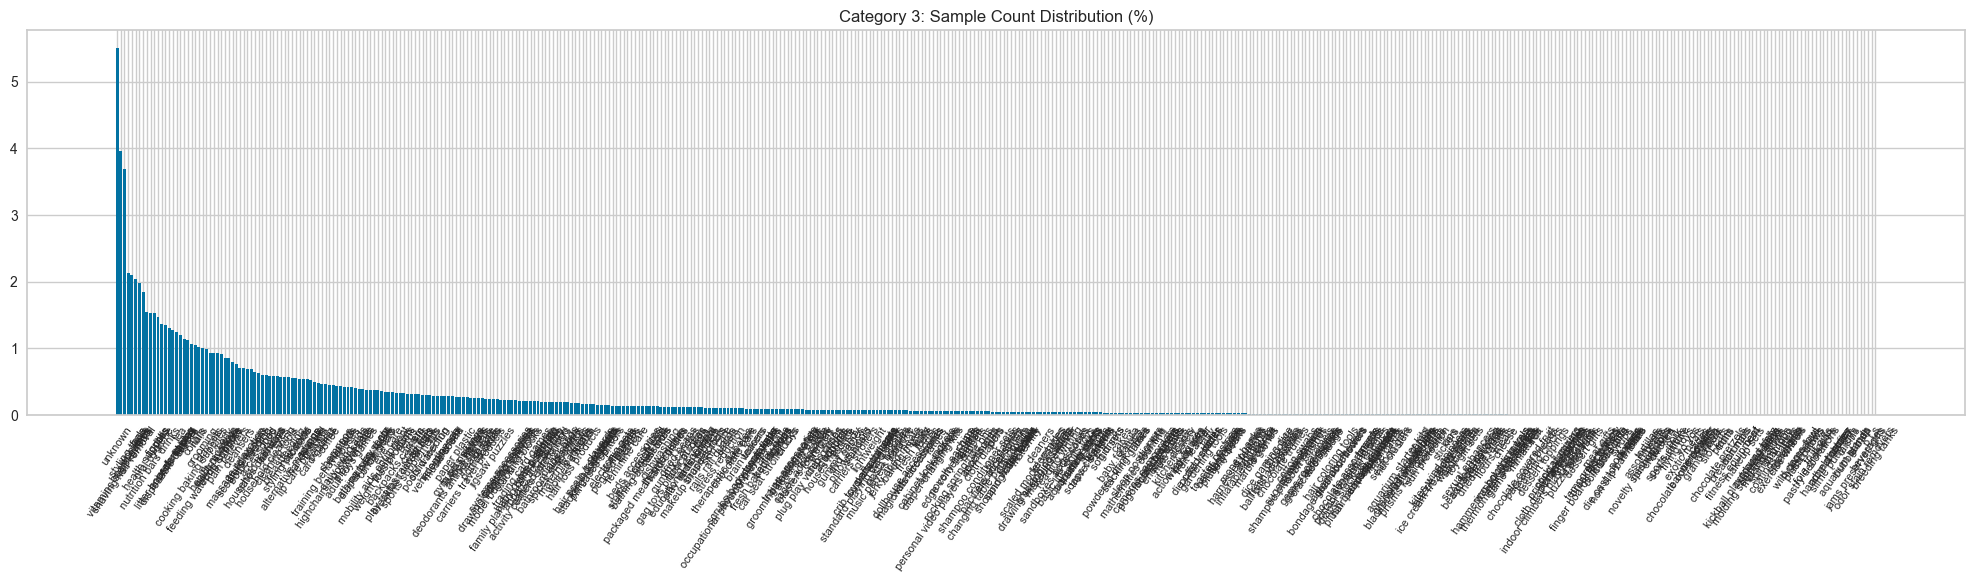

In [20]:
values = (new_df["Cat3"].value_counts(normalize=True) * 100).values.tolist()
columns = (new_df["Cat3"].value_counts(normalize=True) * 100).keys().tolist()

plt.figure(figsize=(25, 5))
plt.bar(columns, values)
plt.xticks(rotation=55, fontsize=8)  
plt.title("Category 3: Sample Count Distribution (%)")
plt.show()

The "Unknown" seems to be a problem! but lets keep it for now ...

Now we need to check the Format and Distribution properties

In [21]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49979 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        49979 non-null  object 
 1   Helpfulness  49979 non-null  object 
 2   Score        49979 non-null  float64
 3   Text         49979 non-null  object 
 4   Cat1         49979 non-null  object 
 5   Cat2         49979 non-null  object 
 6   Cat3         49979 non-null  object 
dtypes: float64(1), object(6)
memory usage: 3.1+ MB


Now need to modify the Data Types

In [22]:
new_df["Helpfulness"].unique()

array(['0/0', '2/4', '2/2', '1/1', '1/6', '9/9', '1/2', '20/24', '18/19',
       '3/3', '20/20', '36/36', '26/26', '5/7', '1/5', '6/7', '67/71',
       '5/8', '7/10', '12/14', '12/12', '34/37', '8/8', '21/22', '77/83',
       '118/125', '0/3', '9/10', '5/6', '44/44', '15/15', '3/6', '17/18',
       '35/37', '0/2', '34/35', '23/31', '31/33', '0/1', '37/37', '13/15',
       '36/38', '124/130', '3/5', '21/21', '29/36', '14/15', '11/11',
       '18/18', '7/8', '42/45', '5/5', '5/13', '74/74', '10/13', '3/4',
       '20/21', '21/26', '9/18', '32/36', '6/6', '4/12', '4/4', '59/63',
       '8/13', '22/22', '3/11', '22/24', '8/9', '29/34', '2/3', '1/4',
       '22/23', '16/18', '13/13', '4/8', '23/23', '1/7', '24/24', '47/47',
       '16/17', '31/31', '21/37', '7/7', '54/55', '3/33', '43/46',
       '51/51', '48/54', '6/8', '58/60', '26/32', '51/67', '28/29', '4/6',
       '34/34', '62/66', '11/12', '40/41', '26/27', '1/3', '139/141',
       '11/14', '19/19', '26/30', '141/143', '33/37', '4/5'

In [23]:
def encode_helpfulness(x):
    val_1, val_2 = map(float, x.split('/'))
    # Division by 0 (Error)
    if val_2 == 0:
        new_val = 0
    else:
        new_val = val_1 / val_2
    
    return new_val

In [24]:
new_df.head()

,Title,Helpfulness,Score,Text,Cat1,Cat2,Cat3
0,Golden Valley Natural Buffalo Jerky,0/0,3.0,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,Westing Game,0/0,5.0,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,Westing Game,0/0,5.0,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,Westing Game,0/0,5.0,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,I SPY A is For Jigsaw Puzzle 63pc,2/4,5.0,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles


In [25]:
new_df['Helpfulness'] = new_df['Helpfulness'].apply(encode_helpfulness)

In [26]:
new_df.head()

,Title,Helpfulness,Score,Text,Cat1,Cat2,Cat3
0,Golden Valley Natural Buffalo Jerky,0.0,3.0,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,Westing Game,0.0,5.0,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,Westing Game,0.0,5.0,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,Westing Game,0.0,5.0,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,I SPY A is For Jigsaw Puzzle 63pc,0.5,5.0,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles


now lets have a look at data dist info

In [27]:
new_df.describe()

,Helpfulness,Score
count,49979.000000,49979.000000
mean,0.427391,4.099322
std,0.465299,1.342018
min,0.000000,1.000000
25%,0.000000,4.000000
50%,0.000000,5.000000
75%,1.000000,5.000000
max,1.000000,5.000000


Better to scale the "Score" values too, although they dont seem be so much distant compared to "Helpfulness" in scale of values

In [28]:
scaler = MinMaxScaler()
new_df["Score"] = scaler.fit_transform(new_df[["Score"]])  
new_df.describe()

,Helpfulness,Score
count,49979.000000,49979.000000
mean,0.427391,0.774830
std,0.465299,0.335504
min,0.000000,0.000000
25%,0.000000,0.750000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


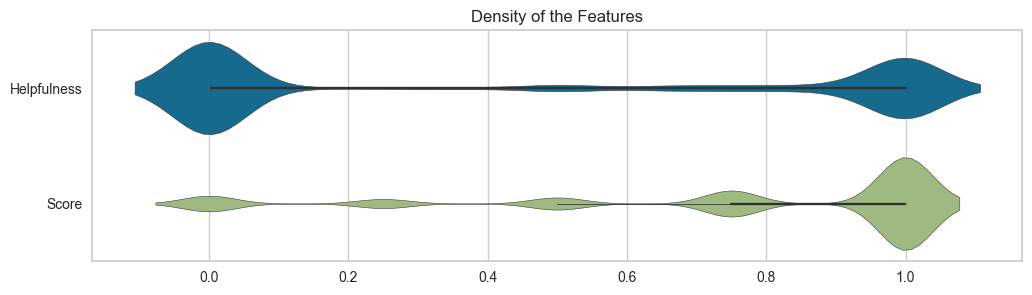

In [29]:
plt.figure(figsize=(12, 3))
sns.violinplot(data=new_df[new_df.columns[1:3]], orient='h')
plt.title("Density of the Features")
plt.show()

In [30]:
new_df.head(5)

,Title,Helpfulness,Score,Text,Cat1,Cat2,Cat3
0,Golden Valley Natural Buffalo Jerky,0.0,0.5,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,Westing Game,0.0,1.0,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,Westing Game,0.0,1.0,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,Westing Game,0.0,1.0,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,I SPY A is For Jigsaw Puzzle 63pc,0.5,1.0,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles


Now lets clean the "Text" column

In [31]:
stop_words = set(stopwords.words('english'))

In [32]:
def clean_text(text):
    """Simple function to clean the input text by removing Junks"""
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)  
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)  
    return text


In [33]:
new_df['Text'] = new_df['Text'].apply(clean_text)
new_df.head()

,Title,Helpfulness,Score,Text,Cat1,Cat2,Cat3
0,Golden Valley Natural Buffalo Jerky,0.0,0.5,description photo product needs changed indica...,grocery gourmet food,meat poultry,jerky
1,Westing Game,0.0,1.0,great book well thought easily imagine events ...,toys games,games,unknown
2,Westing Game,0.0,1.0,first year teacher teaching th grade special r...,toys games,games,unknown
3,Westing Game,0.0,1.0,got book bookfair school looking something sum...,toys games,games,unknown
4,I SPY A is For Jigsaw Puzzle 63pc,0.5,1.0,hi im martine redman created puzzle briarpatch...,toys games,puzzles,jigsaw puzzles


As you can see the junks have been removed from the "Text". For example the second row had "!!!" after "book"

Now Lets extract some features from it ...

In [34]:
# To know how many unique tokens we propably going to need lets see the len of each review sample
new_df["Review_Len"] = new_df["Text"].apply(len) 

In [35]:
new_df["Review_Len"].describe()

count    49979.000000
mean       250.321955
std        233.916726
min          0.000000
25%        105.000000
50%        180.000000
75%        312.000000
max       4587.000000
Name: Review_Len, dtype: float64

In [36]:
new_df["Review_Len"].value_counts().sort_values(ascending=False) 

Review_Len
86      273
82      272
80      267
72      257
96      256
       ... 
1917      1
2115      1
1741      1
1443      1
1186      1
Name: count, Length: 1509, dtype: int64

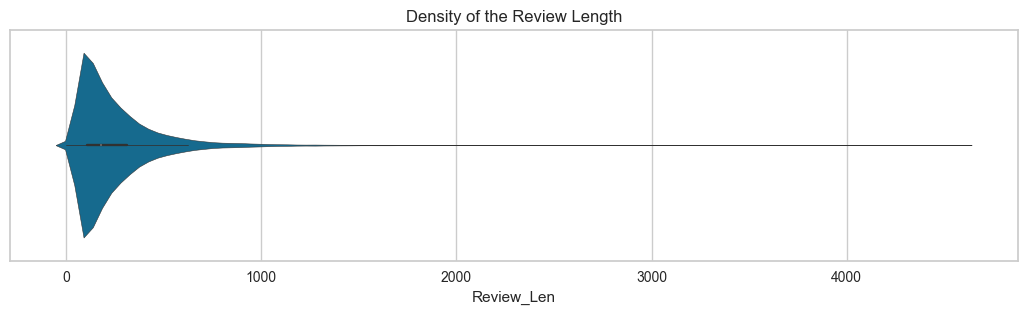

In [37]:
plt.figure(figsize=(13, 3))
sns.violinplot(data=new_df["Review_Len"], orient='h')
plt.title("Density of the Review Length")
plt.show()

Longest review had about 4.5k words. Considering that some of those words are possibly shared, we assume that 3.5k number of tokens (featrues) would be a valid value to begin with. Also we drop the rows that had no reviews. (Len zero)

In [38]:
print(f"Shape before: {new_df.shape}")
new_df.drop(new_df[new_df["Review_Len"] == 0.0].index, inplace=True)
print(f"Shape after: {new_df.shape}")

Shape before: (49979, 8)
Shape after: (49971, 8)


In [39]:
review_vectorizer = TfidfVectorizer(max_features=2000, min_df=5, ngram_range=(1, 1)) # reduced after try-capture experiments

In [40]:
X_1 = review_vectorizer.fit_transform(new_df['Text']).toarray() # we can also test the performance while keeping the matrix Sparse
X_1

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.17723354, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Now we need to do the same thing with Title

In [41]:
del df # No longer needed
# To know how many unique tokens we propably going to need lets see the len of each review sample
new_df["Title_Len"] = new_df["Title"].apply(len) 

In [42]:
new_df["Title_Len"].describe()

count    49971.000000
mean        43.843970
std         20.714466
min          2.000000
25%         30.000000
50%         41.000000
75%         55.000000
max        480.000000
Name: Title_Len, dtype: float64

In [43]:
new_df["Title_Len"].value_counts().sort_values(ascending=False) 

Title_Len
45     1354
33     1299
26     1262
37     1201
41     1157
       ... 
2         1
161       1
130       1
386       1
340       1
Name: count, Length: 172, dtype: int64

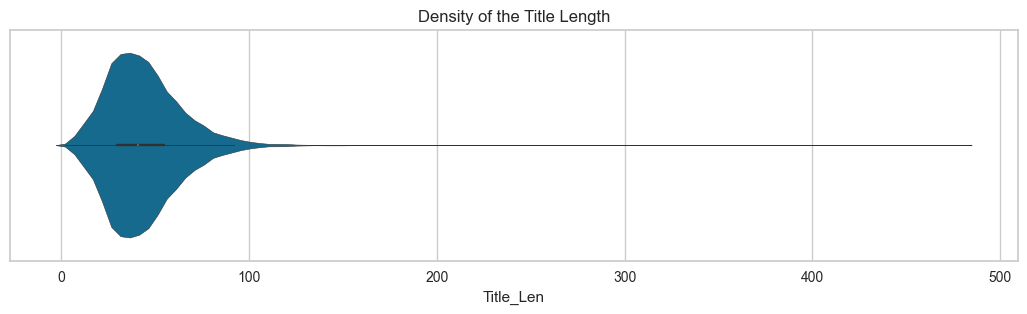

In [44]:
plt.figure(figsize=(13, 3))
sns.violinplot(data=new_df["Title_Len"], orient='h')
plt.title("Density of the Title Length")
plt.show()

lets Keep the titles intact for now and just extract features from it

In [45]:
title_vectorizer = TfidfVectorizer(max_features = 450, min_df=5, ngram_range=(1, 1)) # same as review but here the max length of title is 480 so we decided to pick 350 

In [46]:
X_2 = title_vectorizer.fit_transform(new_df['Title']).toarray() # we can also test the performance while keeping the matrix Sparse
X_2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [47]:
X = np.hstack((X_1, X_2, new_df[['Helpfulness', 'Score']].values))
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.75      ],
       [0.        , 0.        , 0.17723354, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [48]:
new_df.head(3) # just to verify the matrix

,Title,Helpfulness,Score,Text,Cat1,Cat2,Cat3,Review_Len,Title_Len
0,Golden Valley Natural Buffalo Jerky,0.0,0.5,description photo product needs changed indica...,grocery gourmet food,meat poultry,jerky,84,35
1,Westing Game,0.0,1.0,great book well thought easily imagine events ...,toys games,games,unknown,167,12
2,Westing Game,0.0,1.0,first year teacher teaching th grade special r...,toys games,games,unknown,328,12


In [49]:
X.shape # should be 49971, 3352

(49971, 2452)

In [50]:
# Validating the operation
z = 0
nz = 0
    
for k in tqdm(X[:][:].flatten()): # should be 214975242
    if k != 0.0:
        # print(k)
        nz +=1
    else:
        # print("zero")
        z +=1

print(f"zeroes: {z/(z+nz)}\nnon-zeroes: {nz/(z+nz)}")

100%|███████████████████████████████████████████████████████████████| 122528892/122528892 [00:38<00:00, 3213604.65it/s]

zeroes: 0.9879158541644203
non-zeroes: 0.012084145835579742


In [51]:
new_df.shape[0] == X.shape[0] # Sanity Chech

True

So now we add new columns to each row (per sample) representing the values of tf-idf

In [52]:
df = pd.DataFrame(X, columns=[str(i) for i in range(X.shape[1])])
df.shape

(49971, 2452)

In [53]:
new_df = new_df.reset_index(drop=True)
df = df.reset_index(drop=True)

In [54]:
# Putting them altogether
data = pd.concat([new_df, df], axis=1)
# Drop "Title" and "Text" Columns
data.drop(data[["Title", "Text"]], axis=1 , inplace=True) 

data.shape # 49971,2459

(49971, 2459)

In [55]:
del df, new_df #  No Longer Neede
data.head()

,Helpfulness,Score,Cat1,Cat2,Cat3,Review_Len,Title_Len,0,1,2,...,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451
0,0.0,0.5,grocery gourmet food,meat poultry,jerky,84,35,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1,0.0,1.0,toys games,games,unknown,167,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,toys games,games,unknown,328,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,toys games,games,unknown,311,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.5,1.0,toys games,puzzles,jigsaw puzzles,464,33,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0


Now we need to encode the values "Cat1", "Cat2" and "Cat3"

In [56]:
level_1_labels = data[["Cat1"]]
level_2_labels = data[["Cat2"]]
level_3_labels = data[["Cat3"]]
data.drop(data[["Cat1", "Cat2", "Cat3"]], axis=1 , inplace=True) 
data.head()

,Helpfulness,Score,Review_Len,Title_Len,0,1,2,3,4,5,...,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451
0,0.0,0.5,84,35,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1,0.0,1.0,167,12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,328,12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,311,12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.5,1.0,464,33,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0


We should also scale the values of "Review_Len" and "Title_Len" columns if we intend to keep them

In [57]:
scaler = MinMaxScaler()
data["Review_Len"] = scaler.fit_transform(data[["Review_Len"]])  
data["Title_Len"] = scaler.fit_transform(data[["Title_Len"]])  
data.head(3)

,Helpfulness,Score,Review_Len,Title_Len,0,1,2,3,4,5,...,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451
0,0.0,0.5,0.017884,0.069038,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1,0.0,1.0,0.035987,0.020921,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.071101,0.020921,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


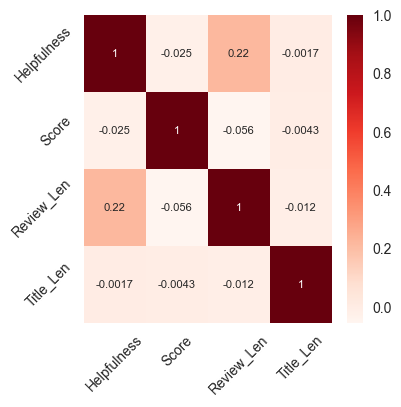

In [58]:
corr = data.iloc[:, :4].corr() # Only the first 4 features
plt.figure(figsize=(4,4))
sns.heatmap(corr,annot=True,annot_kws={'size':8},cmap='Reds')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Initial Benchmarking

### Dont run these cells!

In [59]:
setup(data, 
      target = level_1_labels["Cat1"],
      session_id = 110,
      preprocess = True,
      verbose=True,
      fold =5,
      fix_imbalance=True) 

,Description,Value
0,Session id,110
1,Target,Cat1
2,Target type,Multiclass
3,Target mapping,"baby products: 0, beauty: 1, grocery gourmet food: 2, health personal care: 3, pet supplies: 4, toys games: 5"
4,Original data shape,"(49971, 2457)"
5,Transformed data shape,"(68524, 2457)"
6,Transformed train set shape,"(53532, 2457)"
7,Transformed test set shape,"(14992, 2457)"
8,Numeric features,2456
9,Preprocess,True


In [60]:
compare_models(sort="f1", errors = 'raise', fold=5, include = ['lr', 'svm', 'knn', 'rf', 'lightgbm'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8819,0.9843,0.8819,0.8827,0.8822,0.8542,0.8542,39.2500
lr,Logistic Regression,0.8781,0.0000,0.8781,0.8790,0.8782,0.8500,0.8501,20.0260
svm,SVM - Linear Kernel,0.8753,0.0000,0.8753,0.8776,0.8753,0.8469,0.8474,6.8300
rf,Random Forest Classifier,0.8294,0.9695,0.8294,0.8310,0.8297,0.7891,0.7892,17.7400
knn,K Neighbors Classifier,0.5840,0.8338,0.5840,0.6811,0.5791,0.4981,0.5146,21.5320


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=110, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# cat_1_model = create_model('lightgbm')

In [ ]:
# model_1 = finalize_model(cat_1_model)

LGBM (Light Gradient Boosting Machine) is our choice here. As this model have more hyperparameters compared to SVM and Logistic Regressor (broader search space) that increases the chance of finding dominant model in parameter space. 

Lets fine-tune the model to minimize errors at the first level of the hierarchy, ensuring greater accuracy before progressing to the next classification levels.

In [ ]:
# tune_model(lgbm, n_iter=20, fold=5) # takes so much time to run ...

#### Same approach for Cat_2 and Cat_3

In [59]:
setup(data, 
      target = level_2_labels["Cat2"],
      session_id = 110,
      preprocess = True,
      verbose=True,
      fold =5,
      fix_imbalance = True) 

,Description,Value
0,Session id,110
1,Target,Cat2
2,Target type,Multiclass
3,Target mapping,"action toy figures: 0, arts crafts: 1, baby child care: 2, baby food: 3, baby toddler toys: 4, bath body: 5, bathing skin care: 6, beverages: 7, birds: 8, breads bakery: 9, breakfast foods: 10, building toys: 11, bunny rabbit central: 12, candy chocolate: 13, car seats accessories: 14, cats: 15, cooking baking supplies: 16, dairy eggs: 17, diapering: 18, dogs: 19, dolls accessories: 20, dress up pretend play: 21, electronics for kids: 22, feeding: 23, fish aquatic pets: 24, fragrance: 25, fresh flowers live indoor plants: 26, games: 27, gear: 28, gifts: 29, gourmet gifts: 30, grown up toys: 31, hair care: 32, health baby care: 33, health care: 34, herbs: 35, hobbies: 36, household supplies: 37, learning education: 38, makeup: 39, meat poultry: 40, meat seafood: 41, medical supplies equipment: 42, novelty gag toys: 43, nursery: 44, nutrition wellness: 45, pantry staples: 46, personal care: 47, potty training: 48, pregnancy maternity: 49, produce: 50, puzzles: 51, safety: 52, sauces dips: 53, sexual wellness: 54, skin care: 55, small animals: 56, snack food: 57, sports outdoor play: 58, strollers: 59, stuffed animals plush: 60, tools accessories: 61, tricycles: 62, vehicles remote control: 63"
4,Original data shape,"(49971, 2457)"
5,Transformed data shape,"(171088, 2457)"
6,Transformed train set shape,"(156096, 2457)"
7,Transformed test set shape,"(14992, 2457)"
8,Numeric features,2456
9,Preprocess,True


In [60]:
compare_models(sort="f1", errors = 'raise', fold=5, include = ['lr', 'svm', 'lgb,']) 
# considering the number of classes, LGBM takes so long to fit hence we stopped the run

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:46:00
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7151,0.0000,0.7151,0.7296,0.7204,0.7057,0.7058,85.8320
svm,SVM - Linear Kernel,0.6742,0.0000,0.6742,0.7138,0.6787,0.6642,0.6650,24.6080


KeyboardInterrupt: 

In [ ]:
# cat_2_model = create_model('lr')

In [ ]:
# model_2 = finalize_model(cat_2_model)

In [64]:
# setup(filtered_data,
#       target=filtered_target,
#       session_id=110,
#       preprocess=True,
#       verbose=True,
#       fold=5,
#       fold_strategy="stratifiedkfold",
#       fix_imbalance=True)

In [ ]:
# compare_models(sort="f1", errors = 'raise', fold=5, include = ['lr', 'svm'])

In [ ]:
# cat_3_model = create_model('lgbm')

In [ ]:
# model_3 = finalize_model(cat_3_model)

### First Approach Ended
This approach while being valid, does not handle the heirachy directly. We trained multiple simoultinous models (blind to other level labels) on each category set and fed the data all at the same time to them. This approach while being valid is prone to make mistakes regarding the heirachy of labels.

# Second Approach Begins
The idea is to design a new loss function that penalizes the mistakes in predictions with an ordinal behaviour respecting their position in heirachy. 

For example if during the training the model makes a mistake in classifying the level one (Cat1) label it should get much higher penalty than the incidents where it makes same mistake but on second or third level. This is because, the mistakes on the initial levels would drastically increase the error and should be avoided. Its simmialr to pruning in tree search algorithms.

In [59]:
train_size = 40000
X_train = data.iloc[:train_size]  
X_valid = data.iloc[train_size:]  

In [60]:
X_train

,Helpfulness,Score,Review_Len,Title_Len,0,1,2,3,4,5,...,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451
0,0.0,0.50,0.017884,0.069038,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50
1,0.0,1.00,0.035987,0.020921,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
2,0.0,1.00,0.071101,0.020921,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
3,0.0,1.00,0.067394,0.020921,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
4,0.5,1.00,0.100763,0.064854,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.0,1.00,0.011996,0.071130,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
39996,0.0,0.25,0.025082,0.110879,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25
39997,1.0,0.75,0.044929,0.112971,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.75
39998,0.0,1.00,0.025300,0.066946,0.0,0.24923,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00


In [61]:
# Encode labels
encoded_labels_1, encoded_labels_2, encoded_labels_3 = LabelEncoder(), LabelEncoder(), LabelEncoder()
y1 = encoded_labels_1.fit_transform(level_1_labels["Cat1"])
y2 = encoded_labels_2.fit_transform(level_2_labels["Cat2"])
y3 = encoded_labels_3.fit_transform(level_3_labels["Cat3"])

In [62]:
y1

array([2, 5, 5, ..., 4, 4, 3])

In [63]:
y_train = np.column_stack((y1[:train_size], y2[:train_size], y3[:train_size]))  
y_valid = np.column_stack((y1[train_size:], y2[train_size:], y3[train_size:]))  

In [64]:
y_valid

array([[  3,  34, 188],
       [  1,  39, 169],
       [  4,  19, 210],
       ...,
       [  4,  19,  82],
       [  4,  19, 448],
       [  3,  42, 304]])

In [65]:
y_train

array([[  2,  40, 249],
       [  5,  27, 457],
       [  5,  27, 457],
       ...,
       [  3,  45, 460],
       [  4,  19, 265],
       [  4,  19, 448]])

In [66]:
y_valid.shape

(9971, 3)

In [67]:
# Validation labels for evaluation
y_valid1 = y_valid[:, 0]
y_valid2 = y_valid[:, 1]
y_valid3 = y_valid[:, 2]

In [68]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [69]:
def hierarchical_loss(y_true, y_pred, weights=[80.0, 15.0, 5.0], scale=10.0):
    """Custom loss function with ordinal penalties
    weights: [Level 1 penalty, Level 2 penalty, Level 3 penalty]"""
  
    n_samples = y_true.shape[0]
    n_classes1, n_classes2, n_classes3 = len(encoded_labels_1.classes_), len(encoded_labels_2.classes_), len(encoded_labels_3.classes_)
    
    # Predictions per level
    pred1 = y_pred[:, :n_classes1]  # Level 1 logits (Prediction ratios)
    pred2 = y_pred[:, n_classes1:n_classes1 + n_classes2]  # Level 2 ...
    pred3 = y_pred[:, n_classes1 + n_classes2:]  # Level 3 ...
    true1 = y_true[:, 0].astype(int)
    true2 = y_true[:, 1].astype(int)
    true3 = y_true[:, 2].astype(int)
    
    # Calculate the softmax per predicition ratios
    prob1 = softmax(pred1)
    prob2 = softmax(pred2)
    prob3 = softmax(pred3)
    
    # Gradient and Hessian
    grad = np.zeros_like(y_pred)
    hess = np.zeros_like(y_pred)

    # ----------------------------------------------------------------------------------------------------------------------------------------
    # Level 1 updates ===========================================
    grad[:, :n_classes1] = prob1 - np.eye(n_classes1)[true1]
    hess[:, :n_classes1] = prob1 * (1 - prob1)
    
    # grad[:, :n_classes1] *= weights[0] / n_classes1  # Normalize by class count (Since the level 1 has only 6 possible values but level 3 has 500)
    # grad[:, :n_classes1] *= weights[0] / np.log(n_classes1)  # Normalize by log class count 
    grad[:, :n_classes1] *= weights[0] * scale
    # hess[:, :n_classes1] *= weights[0] / n_classes1
    # hess[:, :n_classes1] *= weights[0] / np.log(n_classes1)
    hess[:, :n_classes1] *= weights[0] * scale
    
    
    # Level 2 updates ===========================================
    start = n_classes1
    end = n_classes1 + n_classes2
    grad[:, start:end] = prob2 - np.eye(n_classes2)[true2]
    hess[:, start:end] = prob2 * (1 - prob2)
    
    # grad[:, start:end] *= weights[1] / n_classes2
    # grad[:, start:end] *= weights[1] / np.log(n_classes2)
    grad[:, start:end] *= weights[1] * scale
    # hess[:, start:end] *= weights[1] / n_classes2
    # hess[:, start:end] *= weights[1] / np.log(n_classes2)
    hess[:, start:end] *= weights[1] * scale
    
    # Level 3 updates ===========================================
    start = n_classes1 + n_classes2
    end = start + n_classes3
    grad[:, start:end] = prob3 - np.eye(n_classes3)[true3]
    hess[:, start:end] = prob3 * (1 - prob3)
    
    # grad[:, start:end] *= weights[2] / n_classes3
    # grad[:, start:end] *= weights[2] / np.log(n_classes3)
    grad[:, start:end] *= weights[2] * scale
    # hess[:, start:end] *= weights[2] / n_classes3
    # hess[:, start:end] *= weights[2] / np.log(n_classes3)
    hess[:, start:end] *= weights[2] * scale

    # ----------------------------------------------------------------------------------------------------------------------------------------
    # Debug: Print stats for first few iterations
    if i < 5:
        print(f"Iter {i+1} - Grad mean: {np.mean(grad):.6f}, Grad std: {np.std(grad):.6f}")
        print(f"Iter {i+1} - Hess mean: {np.mean(hess):.6f}, Hess std: {np.std(hess):.6f}")

    
    return grad, hess

In [70]:
def objective(y_true, y_pred):
    grad, hess = hierarchical_loss(y_true, y_pred.reshape(-1, total_classes))
    return grad, hess

In [71]:
n_classes1 = len(encoded_labels_1.classes_)
print(f"Number of Cat1 Classes: {n_classes1}")
n_classes2 = len(encoded_labels_2.classes_)
print(f"Number of Cat2 Classes: {n_classes2}")
n_classes3 = len(encoded_labels_3.classes_)
print(f"Number of Cat3 Classes: {n_classes3}")
total_classes = n_classes1 + n_classes2 + n_classes3
print(f"Total number of classes: {total_classes}")

Number of Cat1 Classes: 6
Number of Cat2 Classes: 64
Number of Cat3 Classes: 473
Total number of classes: 543


These cells have been commented and minimized because of shape Mismatch problem with LGBM input format

In [72]:
# # Offset labels to make them unique across levels
# y_train_offset = np.column_stack((
#     y_train[:, 0], 
#     y_train[:, 1] + n_classes1, 
#     y_train[:, 2] + n_classes1 + n_classes2
# ))

In [73]:
# # Offset labels for validation
# y_valid_offset = np.column_stack((
#     y_valid[:, 0], 
#     y_valid[:, 1] + n_classes1, 
#     y_valid[:, 2] + n_classes1 + n_classes2
# ))

In [74]:
# # Convert the DataFrame to LightGBM Dataset
# train_data = lgb.Dataset(X_train, label=y_train_offset)
# valid_data = lgb.Dataset(X_valid, label=y_valid_offset, reference=train_data)

In [75]:
# Use dummy labels for Dataset construction
train_data = lgb.Dataset(X_train, label=np.zeros(train_size))  
valid_data = lgb.Dataset(X_valid, label=np.zeros(len(X_valid)), reference=train_data)

The param set here have gone under multiple updates to resolve the issue of "Too Small and Identical Gradients"

In [76]:
# Model parameters
params = {
    'max_depth': 10,         
    'learning_rate': 0.1,
    'num_leaves': 500,        
    'num_class': total_classes,
    'objective': 'multiclass',
    'min_data_in_leaf': 10,
    'min_sum_hessian_in_leaf': 1e-4,
    'verbose': 1             # More LightGBM output
}

booster = lgb.Booster(params=params, train_set=train_data)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250106
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 2456


In [77]:
num_boost_round = 100
best_loss = float('inf')
best_iteration = 0
patience = 25  # how much it should wait before calling off the LGBM
eval_result = {'validation': {'multi_logloss': []}}

The training loop below also have gone under multiple iterations of improvement. The latest issue is the gradients values being too small and having the std of 0.

In [78]:
def update_gradients(preds, train_set):
    # preds: Predictions from booster.predict()
    # train_set: Ignored here, we use y_train directly
    y_pred_reshaped = preds.reshape(-1, total_classes)
    grad, hess = hierarchical_loss(y_train, y_pred_reshaped)
    return grad, hess


for i in tqdm(range(num_boost_round)):
    # Predict raw scores
    y_pred_train = booster.predict(X_train, raw_score=True)  # Shape: (40000, total_classes)
    y_pred_valid = booster.predict(X_valid, raw_score=True)  # Shape: (~10000, total_classes)

    # # Debug: Check if predictions change
    # if i < 5:
    #     print(f"Iter {i+1} - y_pred_train mean: {np.mean(y_pred_train):.6f}, std: {np.std(y_pred_train):.6f}")
    
    # Update booster with custom gradients
    booster.update(fobj=update_gradients)

    # Compute validation loss
    prob1 = softmax(y_pred_valid[:, :n_classes1])  # Shape: (9971, 6)
    prob2 = softmax(y_pred_valid[:, n_classes1:n_classes1 + n_classes2])  # Shape: (9971, 37)
    prob3 = softmax(y_pred_valid[:, n_classes1 + n_classes2:])  # Shape: (9971, 500)

    # Extract probabilities at true labels
    true1 = y_valid[:, 0].astype(int)
    true2 = y_valid[:, 1].astype(int)
    true3 = y_valid[:, 2].astype(int)
    loss1 = -np.mean(np.log(prob1[np.arange(len(true1)), true1] + 1e-10)) # level_1_loss
    loss2 = -np.mean(np.log(prob2[np.arange(len(true2)), true2] + 1e-10)) # level_2_loss
    loss3 = -np.mean(np.log(prob3[np.arange(len(true3)), true3] + 1e-10)) # level_3_loss

    
    # Weighted average of losses [3,2,1]
    valid_loss = (3.0 * loss1 + 2.0 * loss2 + 1.0 * loss3) / 6.0
    eval_result['validation']['multi_logloss'].append(valid_loss)
    print(f"[{i+1}] validation's multi_logloss: {valid_loss:.4f}")

    
    # Early stopping callback
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_iteration = i
    elif i - best_iteration >= patience:
        print(f"Early stopping, best epoch is: [{best_iteration + 1}] Loss: {best_loss:.4f}")
        break




  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function
Iter 1 - Grad mean: -0.000000, Grad std: 32.055904
Iter 1 - Hess mean: 1.591560, Hess std: 11.598290
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


  1%|▊                                                                                 | 1/100 [00:02<03:46,  2.29s/it]

[1] validation's multi_logloss: 3.3087
Iter 2 - Grad mean: -0.000000, Grad std: 32.055904
Iter 2 - Hess mean: 1.591560, Hess std: 11.598290


  2%|█▋                                                                                | 2/100 [00:04<03:55,  2.40s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2] validation's multi_logloss: 3.3087
Iter 3 - Grad mean: -0.000000, Grad std: 32.055904
Iter 3 - Hess mean: 1.591560, Hess std: 11.598290
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


  3%|██▍                                                                               | 3/100 [00:07<04:01,  2.49s/it]

[3] validation's multi_logloss: 3.3087
Iter 4 - Grad mean: -0.000000, Grad std: 32.055904
Iter 4 - Hess mean: 1.591560, Hess std: 11.598290
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


  4%|███▎                                                                              | 4/100 [00:09<03:53,  2.43s/it]

[4] validation's multi_logloss: 3.3087
Iter 5 - Grad mean: -0.000000, Grad std: 32.055904
Iter 5 - Hess mean: 1.591560, Hess std: 11.598290


  5%|████                                                                              | 5/100 [00:12<03:50,  2.42s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[5] validation's multi_logloss: 3.3087


  6%|████▉                                                                             | 6/100 [00:14<03:37,  2.31s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[6] validation's multi_logloss: 3.3087


  7%|█████▋                                                                            | 7/100 [00:16<03:27,  2.23s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[7] validation's multi_logloss: 3.3087


  8%|██████▌                                                                           | 8/100 [00:18<03:19,  2.17s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[8] validation's multi_logloss: 3.3087


  9%|███████▍                                                                          | 9/100 [00:20<03:14,  2.14s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[9] validation's multi_logloss: 3.3087


 10%|████████                                                                         | 10/100 [00:22<03:11,  2.12s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[10] validation's multi_logloss: 3.3087


 11%|████████▉                                                                        | 11/100 [00:24<03:07,  2.10s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[11] validation's multi_logloss: 3.3087


 12%|█████████▋                                                                       | 12/100 [00:26<03:04,  2.09s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[12] validation's multi_logloss: 3.3087


 13%|██████████▌                                                                      | 13/100 [00:28<03:01,  2.09s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[13] validation's multi_logloss: 3.3087


 14%|███████████▎                                                                     | 14/100 [00:30<03:00,  2.09s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[14] validation's multi_logloss: 3.3087


 15%|████████████▏                                                                    | 15/100 [00:32<02:58,  2.11s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[15] validation's multi_logloss: 3.3087


 16%|████████████▉                                                                    | 16/100 [00:34<02:54,  2.08s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[16] validation's multi_logloss: 3.3087


 17%|█████████████▊                                                                   | 17/100 [00:37<02:52,  2.08s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[17] validation's multi_logloss: 3.3087


 18%|██████████████▌                                                                  | 18/100 [00:39<02:50,  2.08s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[18] validation's multi_logloss: 3.3087


 19%|███████████████▍                                                                 | 19/100 [00:41<02:49,  2.09s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[19] validation's multi_logloss: 3.3087


 20%|████████████████▏                                                                | 20/100 [00:43<02:47,  2.09s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[20] validation's multi_logloss: 3.3087


 21%|█████████████████                                                                | 21/100 [00:45<02:44,  2.08s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[21] validation's multi_logloss: 3.3087


 22%|█████████████████▊                                                               | 22/100 [00:47<02:42,  2.08s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[22] validation's multi_logloss: 3.3087


 23%|██████████████████▋                                                              | 23/100 [00:49<02:40,  2.09s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[23] validation's multi_logloss: 3.3087


 24%|███████████████████▍                                                             | 24/100 [00:51<02:38,  2.08s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[24] validation's multi_logloss: 3.3087


 25%|████████████████████▎                                                            | 25/100 [00:53<02:36,  2.08s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[25] validation's multi_logloss: 3.3087


 25%|████████████████████▎                                                            | 25/100 [00:55<02:47,  2.24s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[26] validation's multi_logloss: 3.3087
Early stopping, best epoch is: [1] Loss: 3.3087


An error raised while running the lgb.train() because of flatteting the labels and features into a single multiclass vector, hence we decided to go a bit deeper into the LGBM and redefine some built-in functions

In [ ]:
# # Lets define a training plan 
# params = {
#     'objective': objective,  # Our Custom loss
#     'num_class': total_classes,  # Total unique "classes"
#     'max_depth': 5,
#     'learning_rate': 0.1,
#     'num_leaves': 20,
#     'metric': 'multi_logloss',  # For monitoring
#     'verbose': 1
# }

# eval_result = {}  # For future ViZ

# bst = lgb.train(
#     params,
#     train_data,
#     num_boost_round=50,
#     valid_sets=[valid_data],
#     valid_names=['validation'],
#     callbacks=[
#         lgb.early_stopping(stopping_rounds=15),  
#         lgb.log_evaluation(period=1),            # Log every epoch
#         lgb.record_evaluation(eval_result)       # Log the metrics
#     ]
# )


Unfortunately we could not manage to reach a reliable soloution for the issue of "Small Identical Gradients" due to the comlpex nature of the idea and also the time-limit. However, considering how much time and effort I have dedicated to this idea, I decided to share it beside the initial work. 
To be continued

Thank you

S Mohammad Hossein Hashemi